In [1]:
import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
np.random.seed(42)
print(f'Keras: {keras.__version__}')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Keras: 2.2.4


In [3]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

In [4]:
def display_sample_imgs(xtrain, ytrain, gray=False):
    fig, axes = plt.subplots(1, 10, figsize=(20, 10))
    counter = 0
    for i in range(100, 110):
        axes[counter].set_title(ytrain[i])
        if gray:
            axes[counter].imshow(xtrain[i], cmap='gray')
        else:
            axes[counter].imshow(xtrain[i])
        axes[counter].axis('off')
        counter += 1
    fig.tight_layout()

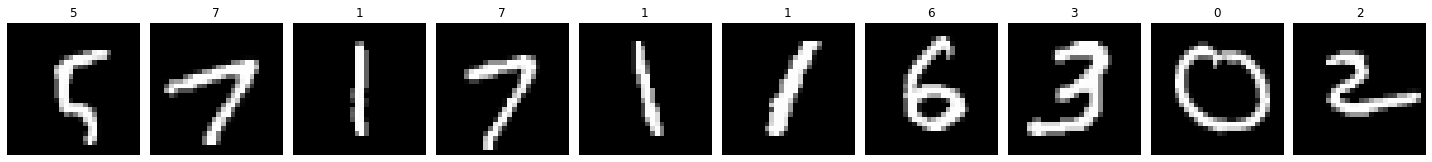

In [5]:
display_sample_imgs(xtrain, ytrain, gray=True)

In [6]:
xtrain = np.expand_dims(xtrain/255, -1)
xtest = np.expand_dims(xtest/255, -1)
input_shape = xtrain[0].shape
print(f'Input shape: {input_shape}')

Input shape: (28, 28, 1)


In [7]:
latent_dim = 2

def latent_space(inputs):
    mu, sigma = inputs
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return mu + K.exp(0.5*sigma)*epsilon

In [8]:
encoder_input = layers.Input(shape=input_shape)

e1 = layers.Conv2D(8, 3, padding='same', activation='relu')(encoder_input)
e1 = layers.BatchNormalization()(e1)

e2 = layers.Conv2D(16, 3, padding='same', activation='relu')(e1)
e2 = layers.BatchNormalization()(e2)

e3 = layers.Conv2D(32, 3, padding='same', activation='relu')(e2)
e3 = layers.BatchNormalization()(e3)
e3 = layers.MaxPooling2D(2)(e3)

e4 = layers.Conv2D(32, 3, padding='same', activation='relu')(e3)
e4 = layers.BatchNormalization()(e4)

e5 = layers.Conv2D(64, 3, padding='same', activation='relu')(e4)
e5 = layers.BatchNormalization()(e5)

e6 = layers.Conv2D(128, 3, padding='same', activation='relu')(e5)
e6 = layers.BatchNormalization()(e6)
e6 = layers.MaxPooling2D(2)(e6)

encoder = layers.Flatten()(e6)
mu = layers.Dense(latent_dim)(encoder)
sigma = layers.Dense(latent_dim)(encoder)

latent_space = layers.Lambda(latent_space, output_shape=(latent_dim,))([mu, sigma])

encoder = Model(encoder_input, latent_space)
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 16)   1168        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [10]:
conv_shape = K.int_shape(e6)
print(conv_shape)

(None, 7, 7, 128)


In [11]:
decoder_input = layers.Input(shape=(latent_dim,))
decoder = layers.Dense(np.prod(conv_shape[1:]), activation='relu')(decoder_input)
decoder = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

d1 = layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(decoder)
d1 = layers.BatchNormalization()(d1)

d2 = layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(d1)
d2 = layers.BatchNormalization()(d2)

d3 = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(d2)
d3 = layers.BatchNormalization()(d3)
d3 = layers.UpSampling2D(2)(d3)

d4 = layers.Conv2DTranspose(32, 3, padding='same', activation='relu')(d3)
d4 = layers.BatchNormalization()(d4)

d5 = layers.Conv2DTranspose(16, 3, padding='same', activation='relu')(d4)
d5 = layers.BatchNormalization()(d5)

d6 = layers.Conv2DTranspose(8, 3, padding='same', activation='relu')(d5)
d6 = layers.BatchNormalization()(d6)
d6 = layers.UpSampling2D(2)(d6)

decoder_out = layers.Conv2DTranspose(input_shape[-1], kernel_size=3, padding='same', activation='sigmoid')(d6)

decoder = Model(decoder_input, decoder_out)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 6272)              18816     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 128)         147584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 64)          256       
__________

In [12]:
def reconstruction_loss(true, pred):
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred))*np.prod(input_shape[:2])
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

In [13]:
opt = Adam(lr=1e-4, amsgrad=True)
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.compile(optimizer=opt, loss=reconstruction_loss)

In [14]:
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode="auto",
)
reduce_lr = ReduceLROnPlateau(
    monitor     = 'val_loss',
    factor      = 0.1,
    patience    = 2,
    verbose     = 0,
    mode        = 'min',
    min_delta   = 0.01,
    min_lr      = 0
)

In [15]:
history = vae.fit(x=xtrain, 
                  y=xtrain,
                  epochs=100,
                  batch_size=32,
                  validation_data=(xtest, xtest),
                  callbacks=[early_stop, reduce_lr])

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 44s 728us/step - loss: 305.8529 - val_loss: 186.9380
Epoch 2/500
60000/60000 [==============================] - 40s 663us/step - loss: 173.0852 - val_loss: 164.6573
Epoch 3/500
60000/60000 [==============================] - 41s 679us/step - loss: 163.9888 - val_loss: 162.3995
Epoch 4/500
60000/60000 [==============================] - 41s 679us/step - loss: 160.7323 - val_loss: 159.6923
Epoch 5/500
60000/60000 [==============================] - 41s 684us/step - loss: 158.6386 - val_loss: 158.6405
Epoch 6/500
60000/60000 [==============================] - 41s 687us/step - loss: 157.4178 - val_loss: 155.6304
Epoch 7/500
60000/60000 [==============================] - 41s 678us/step - loss: 156.4006 - val_loss: 155.1588
Epoch 8/500
60000/60000 [==============================] - 41s 677us/step - loss: 155.4729 - val_loss: 153.5739
Epoch 9/500
60000/60000 [=============================

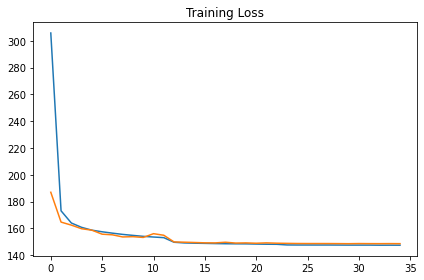

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.tight_layout()

In [17]:
def plot_latent_distribution(xtrain, ytrain):
    encoded = encoder.predict(xtrain)
    plt.figure(figsize=(14,12))
    plt.scatter(encoded[:,0], encoded[:,1], s=2, c=ytrain, cmap='hsv')
    plt.colorbar()
    plt.grid()

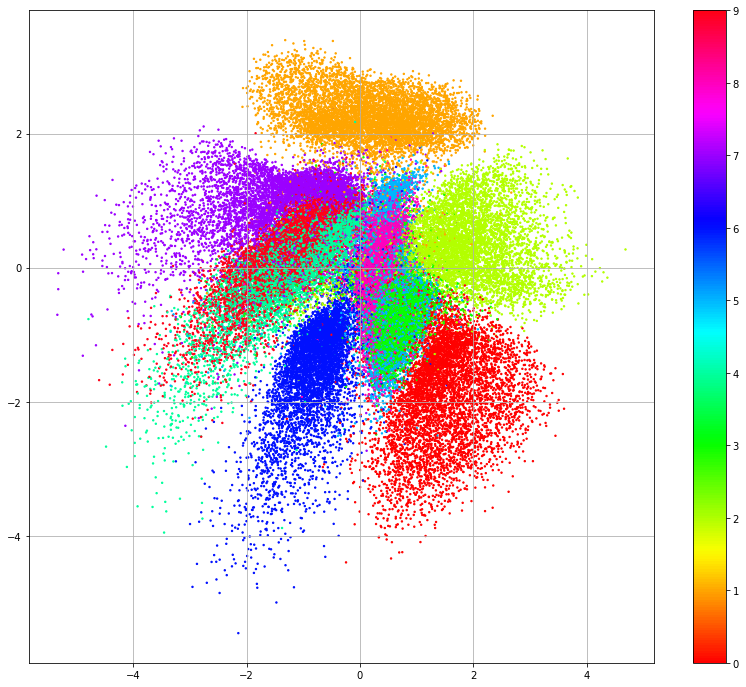

In [18]:
plot_latent_distribution(xtrain, ytrain)

In [19]:
def generate_latent_imgs(decoder, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

            
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

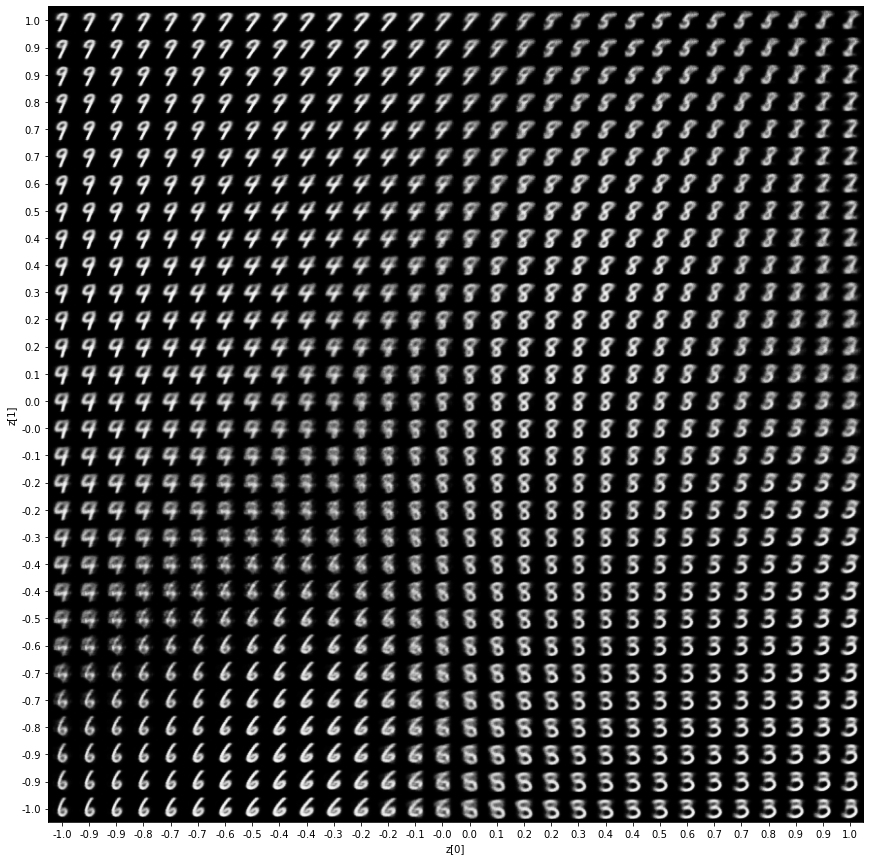

In [20]:
generate_latent_imgs(decoder)